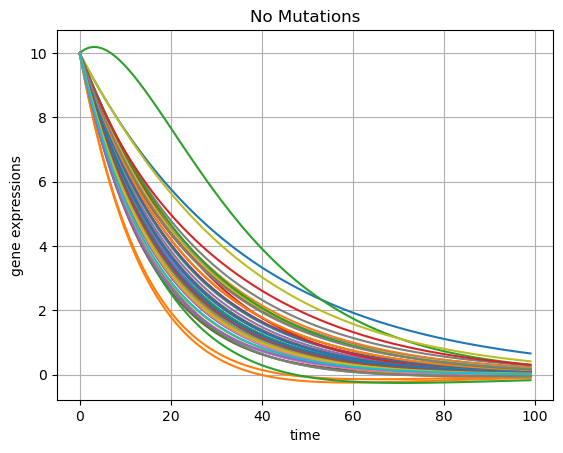

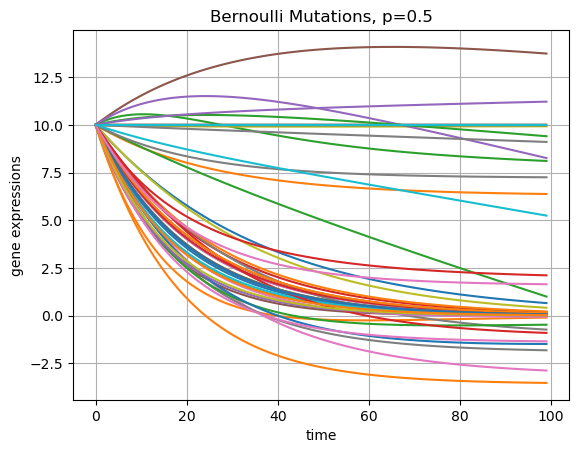

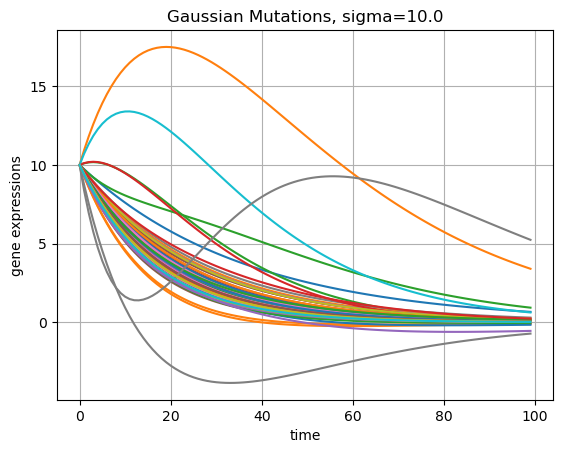

In [4]:
import pytest
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.normal import Normal


from flecs.cell_population import TestCellPop
from flecs.mutation import apply_bernoulli_mutation, apply_gaussian_mutation
from flecs.trajectory import simulate_deterministic_trajectory
from flecs.utils import plot_trajectory, set_seed


class MyTestCellPop(TestCellPop):
    def __init__(self, n_cells: int = 1):
        super().__init__(n_cells=n_cells)

    def compute_production_rates(self):
        self.set_production_rates_to_zero()
        for e_type in self.edge_types:
            src_n_type, interaction_type, tgt_n_type = e_type
            
            self[tgt_n_type].production_rates += self[e_type].simple_conv(
                x=self[src_n_type].state,
                edge_index=self[e_type].edges.T,
                edge_weight=self[e_type].weights,
            )

        # TODO: replace with something else.
        #self.production_rates = torch.sigmoid(self.production_rates)


def init_test_cell_pop(n_cells):
    set_seed(0)
    my_cells = MyTestCellPop(n_cells=n_cells)
    my_cells["gene"].init_param(name="alpha", dist=Normal(5, 1))

    return my_cells

def test_mutations(n_cells=3):

    # Simulate trajectory
    my_cells = init_test_cell_pop(n_cells)
    cell_traj = simulate_deterministic_trajectory(my_cells, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj[:, 0], legend=False, title="No Mutations")
    plt.show()

    # Simulate trajectory with bernoulli mutation to nodes.
    p = 0.5
    my_cells = init_test_cell_pop(n_cells)
    apply_bernoulli_mutation(my_cells["gene"], "alpha", p=p, n_cells=n_cells)
    cell_traj = simulate_deterministic_trajectory(my_cells, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj[:, 0], legend=False, 
                    title="Bernoulli Mutations, p={}".format(p))
    plt.show()

    # Simulate trajectory with gaussian mutation to edges [gene - activation - gene].
    sigma = 10.0
    my_cells = init_test_cell_pop(n_cells)
    apply_gaussian_mutation(my_cells['gene', 'activation', 'gene'], "weights", sigma=sigma, n_cells=n_cells)
    cell_traj = simulate_deterministic_trajectory(my_cells, torch.linspace(0, 1, 100))
    plot_trajectory(cell_traj[:, 0], legend=False, 
                    title="Gaussian Mutations, sigma={}".format(sigma))
    plt.show()

test_mutations()